### Library

In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from collections import Counter

warnings.filterwarnings('ignore')
sys.path.append('..')
from src.utils import setup_workspace, seed, get_device

In [2]:
PROJECT_ROOT = "/Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation"
SEED = 42

setup_workspace(PROJECT_ROOT)
seed(SEED)
get_device()

Env: Local | Root: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation
Device: mps


device(type='mps')

### Multi_Camera Dataset

In [3]:
from src.data.dataset import DatasetLoader

DATA_ROOT = Path("dataset/Multi Camera Semantic Segmentation")

# Train data
train_dataset = DatasetLoader(
    data_root=DATA_ROOT,
    split="train",
    camera="left",
)

# Val data
val_dataset = DatasetLoader(
    data_root=DATA_ROOT,
    split="val",
    camera="left",
)

Train samples: 516
Val samples: 182


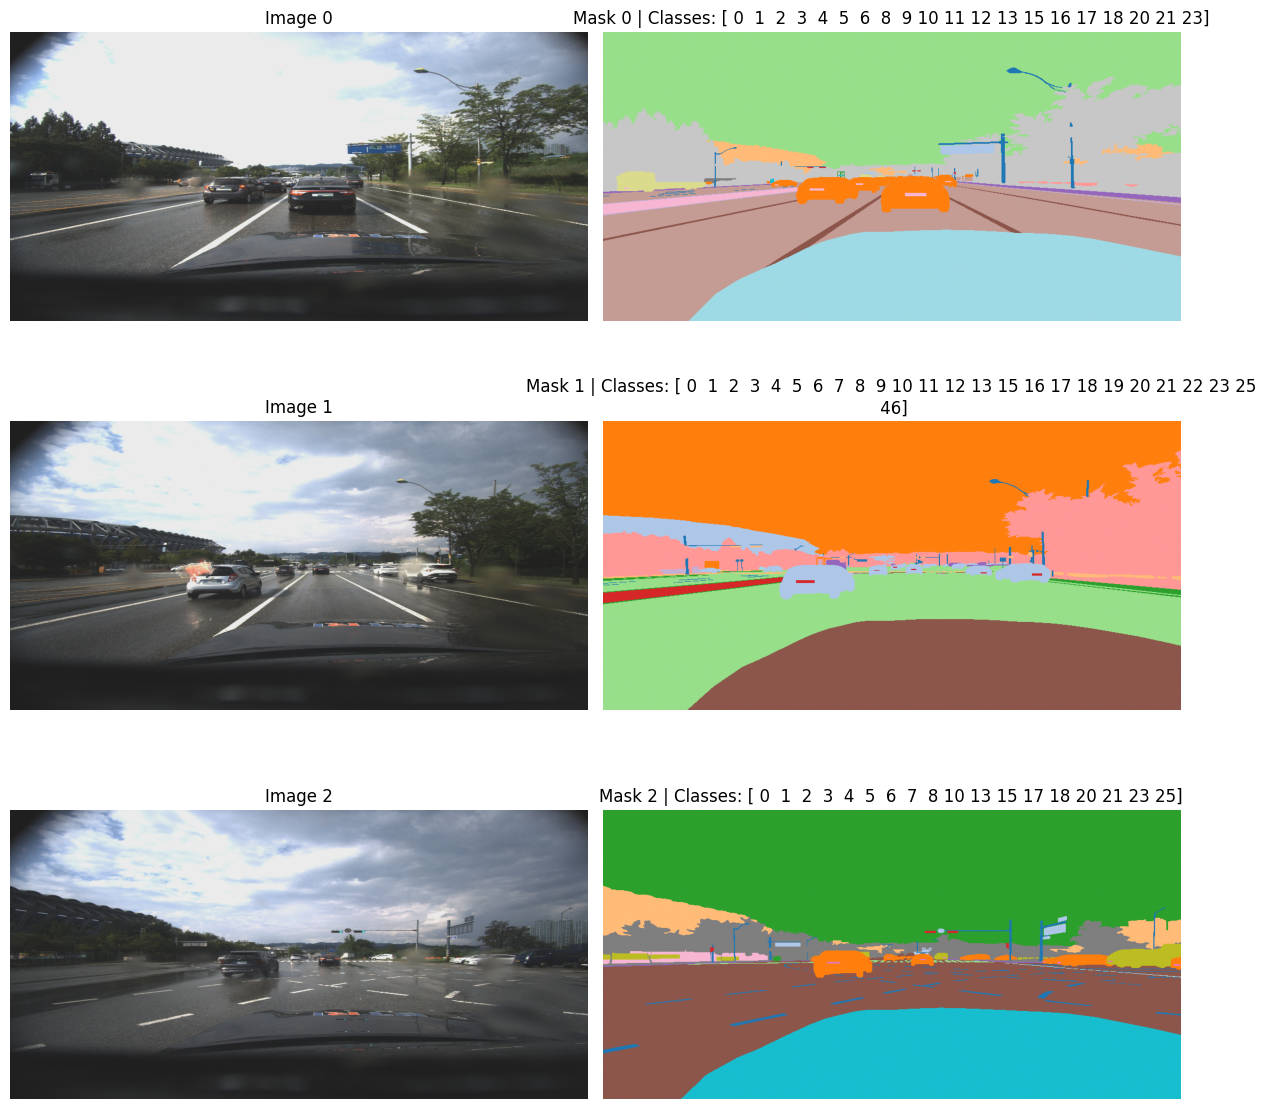

In [4]:
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

for i in range(num_samples):
    img, mask = train_dataset[i]

    # tensor → numpy (C, H, W) → (H, W, C)
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    # 이미지
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Image {i}")
    axes[i, 0].axis("off")

    # 마스크
    axes[i, 1].imshow(mask_np, cmap="tab20")
    axes[i, 1].set_title(f"Mask {i} | Classes: {np.unique(mask_np)}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

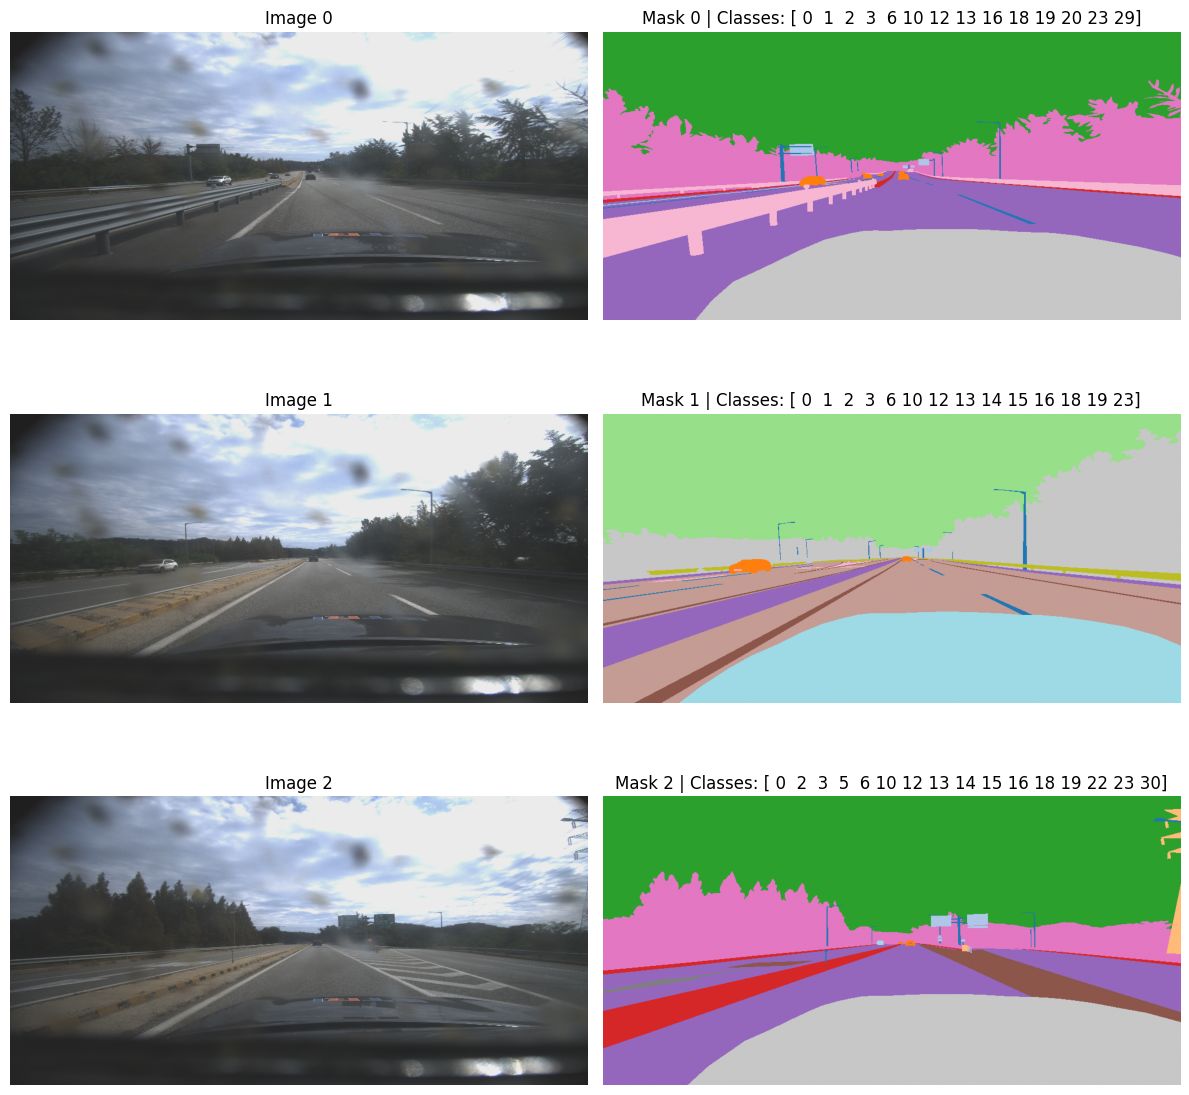

In [5]:
num_samples = 3
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))

for i in range(num_samples):
    img, mask = val_dataset[i]

    # tensor → numpy (C, H, W) → (H, W, C)
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    # 이미지
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Image {i}")
    axes[i, 0].axis("off")

    # 마스크
    axes[i, 1].imshow(mask_np, cmap="tab20")
    axes[i, 1].set_title(f"Mask {i} | Classes: {np.unique(mask_np)}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# from src.data.dataset import generate_class_info
# class_info = generate_class_info(DATA_ROOT)
# class_info

class_info = pd.read_csv(f"{DATA_ROOT}/class_info.csv")
class_info

class_id     class_name  count
0          0           pole  14713
1          1          whdot   6806
2          2   traffic sign   5151
3          3            car   3900
4          4       building   3427
..       ...            ...    ...
57        57  right-forward      2
58        58        trailer      1
59        59       number 1      1
60        60      polegroup      1
61        61     rail track      1

[62 rows x 3 columns]

In [ ]:
from src.data.dataset import get_dataset_info

train_df = get_dataset_info(DATA_ROOT, split="train")
val_df = get_dataset_info(DATA_ROOT, split="val")
df = pd.concat([train_df, val_df], ignore_index=True)
df.head()

Loading val: 100%|██████████| 182/182 [00:00<00:00, 954.55it/s] 


img_path  \
0  dataset/Multi Camera Semantic Segmentation/lef...   
1  dataset/Multi Camera Semantic Segmentation/lef...   
2  dataset/Multi Camera Semantic Segmentation/lef...   
3  dataset/Multi Camera Semantic Segmentation/lef...   
4  dataset/Multi Camera Semantic Segmentation/lef...   

                                          label_path           folder  split  \
0  dataset/Multi Camera Semantic Segmentation/lab...  20220817_153937  train   
1  dataset/Multi Camera Semantic Segmentation/lab...  20220817_153937  train   
2  dataset/Multi Camera Semantic Segmentation/lab...  20220817_153937  train   
3  dataset/Multi Camera Semantic Segmentation/lab...  20220817_153937  train   
4  dataset/Multi Camera Semantic Segmentation/lab...  20220817_153937  train   

   width  height                                            classes  \
0   2048    1536  [sky, vegetation, building, building, building...   
1   2048    1536  [sky, vegetation, vegetation, road, building, ...   
2   2048    1536  [sky, vegetation, building, building, building...   
3   2048    1536  [sky, vegetation, building, building, building...   
4   2048    1536  [sky, vegetation, building, building, building...   

   num_objects                                     unique_classes  num_classes  
0           98  [traffic light, sky, license plate, car, ego v...           20  
1          142  [traffic light, sky, license plate, car, ego v...           25  
2          164  [traffic light, sky, license plate, car, pole,...           18  
3          130  [traffic light, sky, license plate, car, ego v...           20  
4          158  [traffic light, sky, license plate, car, ego v...           24

### Class Imbalnce

Total classes: 62


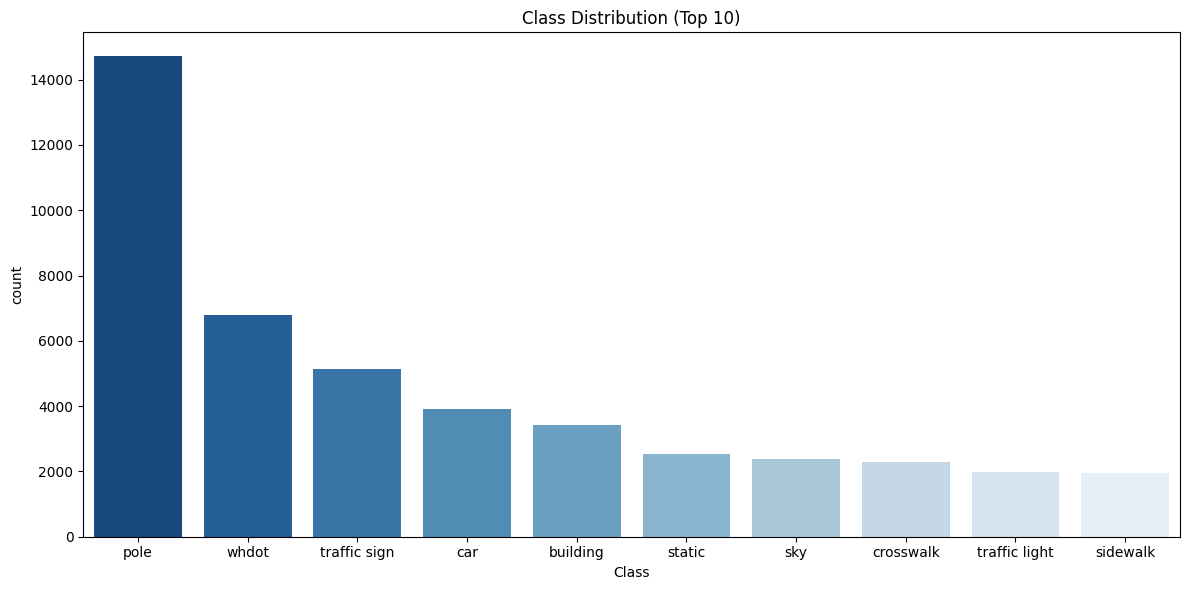

In [ ]:
all_classes = []
for classes in df['classes']:
    all_classes.extend(classes)

# 클래스별 등장 횟수
class_counts = Counter(all_classes)
class_df = pd.DataFrame(
    class_counts.most_common(),
    columns=['class', 'count']
)
class_df['ratio'] = class_df['count'] / class_df['count'].sum() * 100
print(f"Total classes: {len(class_df)}")

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=class_df['class'][:10], y=class_df['count'][:10], palette='Blues_r')
plt.xlabel('Class')
plt.title('Class Distribution (Top 10)')
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

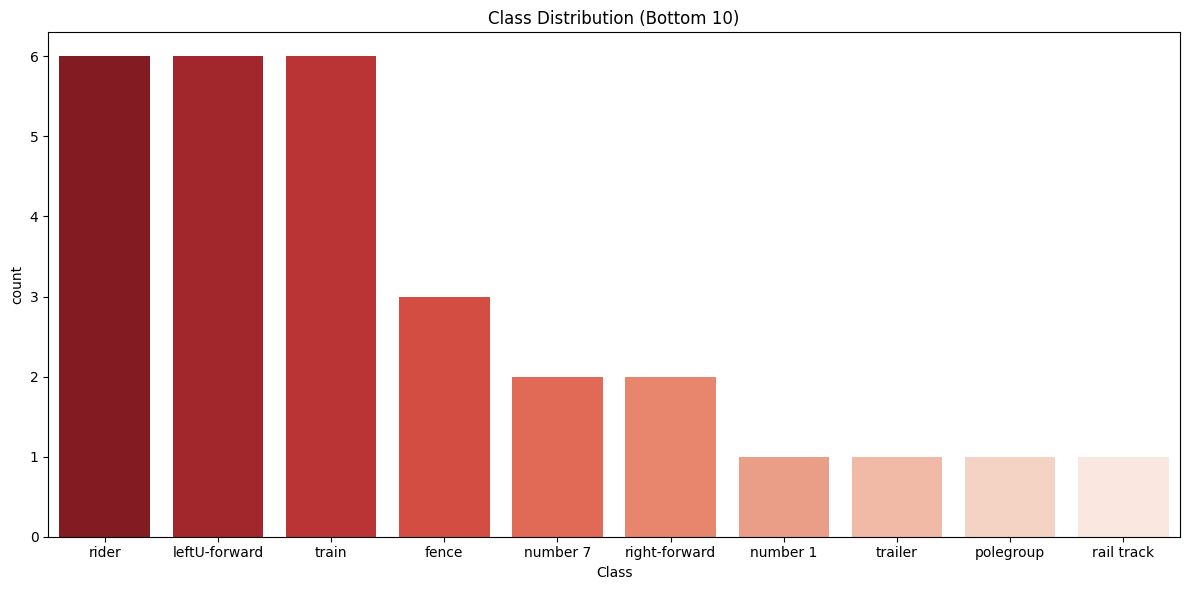

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=class_df['class'][-10:], y=class_df['count'][-10:], palette='Reds_r')
plt.xlabel('Class')
plt.title('Class Distribution (Bottom 10)')
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 이미지당 객체 수 분석

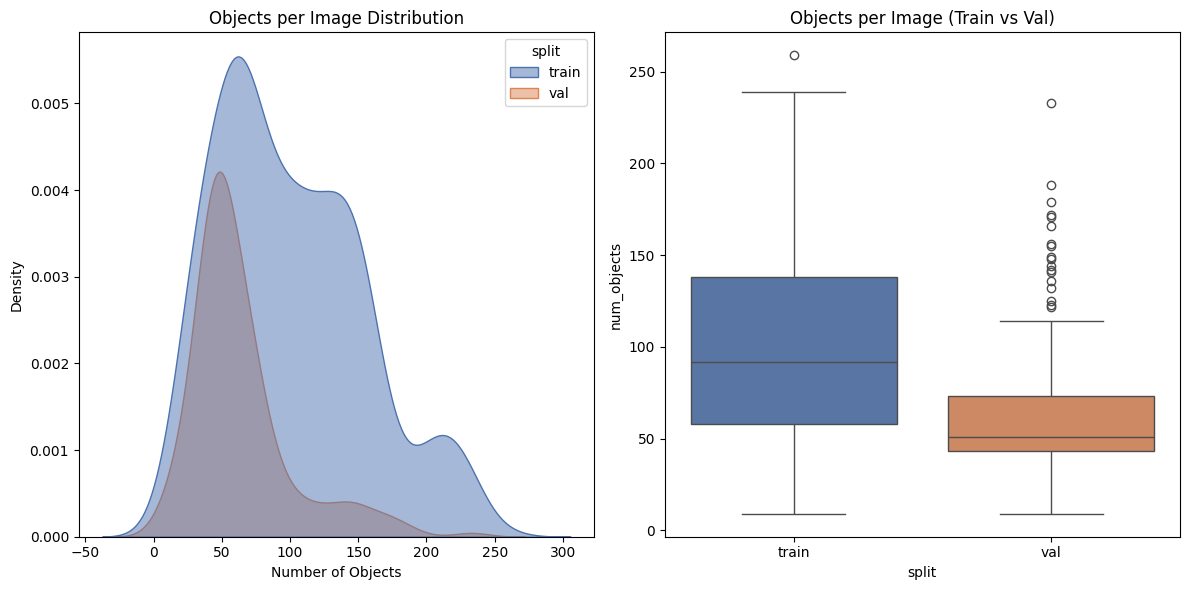

In [ ]:
palette = {
    "train": "#4C72B0",  # 파랑
    "val": "#DD8452"     # 주황
}

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(
    data=df,
    x="num_objects",
    hue="split",
    fill=True,
    alpha=0.5,
    palette=palette
)
plt.xlabel("Number of Objects")
plt.ylabel("Density")
plt.title("Objects per Image Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(
    x="split",
    y="num_objects",
    data=df,
    hue="split",
    palette=palette,
    legend=False
)
plt.title("Objects per Image (Train vs Val)")

plt.tight_layout()
plt.show()

### 차선 클래스 분석

차선 관련 클래스 수: 8


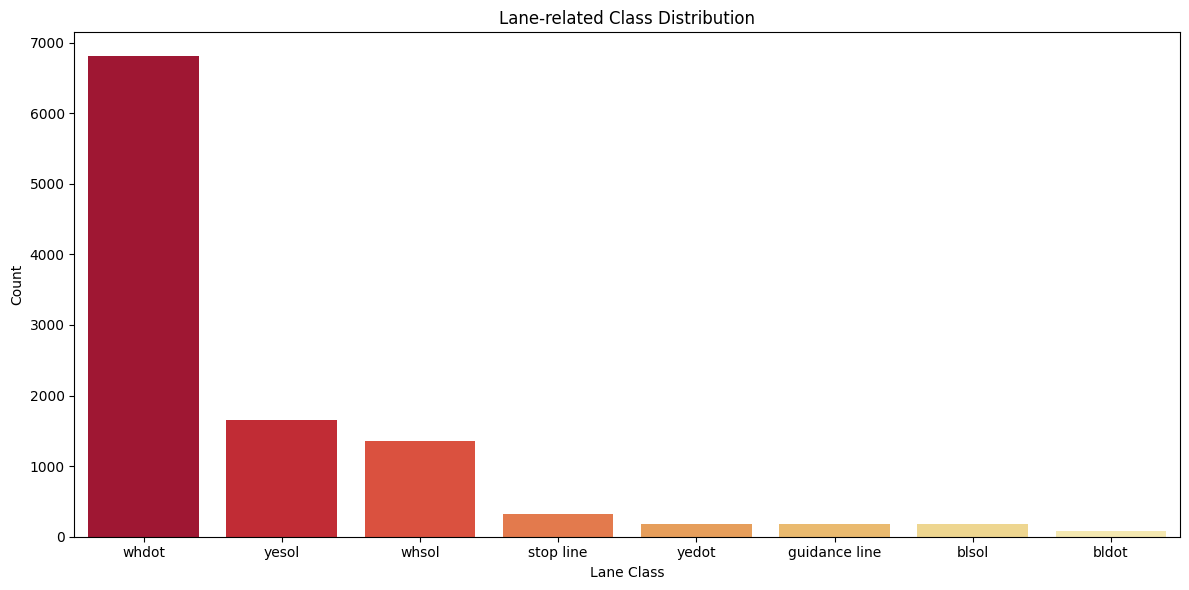

In [ ]:
# 차선 관련 클래스 필터링
lane_keywords = ['lane', 'sol', 'dot', 'line', 'wh', 'ye', 'bl']

lane_classes = [cls for cls in class_df['class']
                if any(kw in cls.lower() for kw in lane_keywords)]

lane_df = class_df[class_df['class'].isin(lane_classes)]
print(f"차선 관련 클래스 수: {len(lane_df)}")

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='class', y='count', data=lane_df, palette='YlOrRd_r')
plt.xlabel('Lane Class')
plt.ylabel('Count')
plt.title('Lane-related Class Distribution')
plt.tight_layout()
plt.show()

In [ ]:
pixel_counts = Counter()
error_count = 0
error_files = []

for i in tqdm(range(len(train_dataset)), desc="Train"):
    try:
        _, mask = train_dataset[i]
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        for cls_id, cnt in zip(unique, counts):
            pixel_counts[cls_id] += cnt
    except Exception as e:
        error_count += 1
        error_files.append(train_dataset.get_sample_info(i)['img_path'])

for i in tqdm(range(len(val_dataset)), desc="Val"):
    try:
        _, mask = val_dataset[i]
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        for cls_id, cnt in zip(unique, counts):
            pixel_counts[cls_id] += cnt
    except Exception as e:
        error_count += 1
        error_files.append(val_dataset.get_sample_info(i)['img_path'])

print(f"\nTotal errors: {error_count} / {len(train_dataset) + len(val_dataset)}")

Val: 100%|██████████| 182/182 [00:08<00:00, 22.25it/s]


Total errors: 1 / 698


### 클래스별 픽셀 비율 (Top 10)

- 전체 이미지에서 각 클래스가 차지하는 총 면적 비율

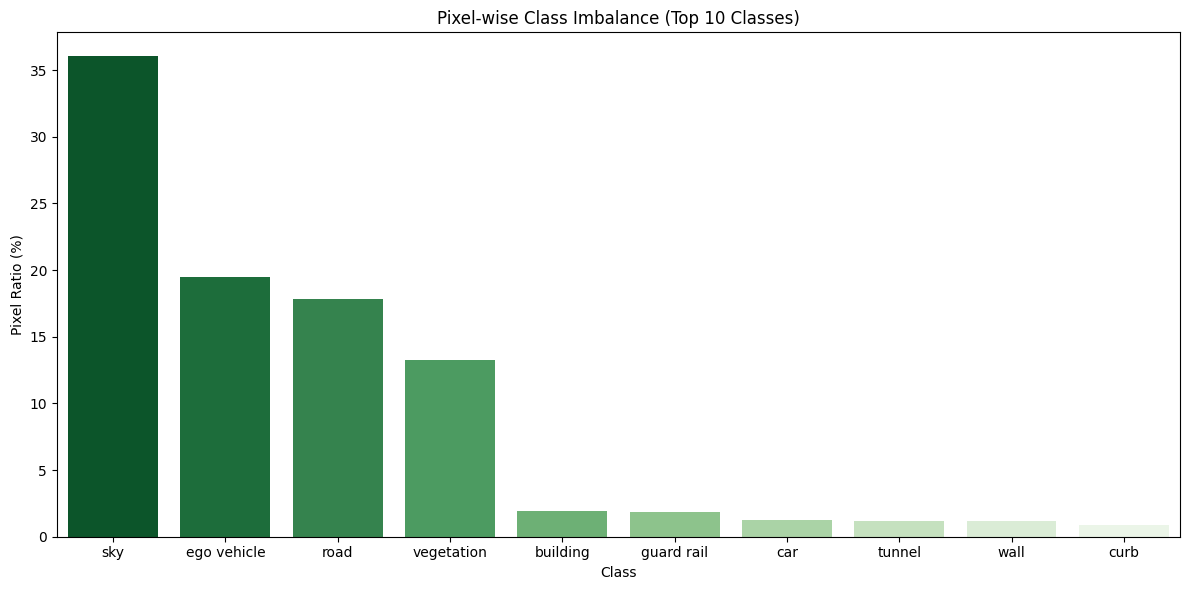

In [ ]:
pixel_df = pd.DataFrame(pixel_counts.most_common(), columns=['class_id', 'pixel_count'])
pixel_df['ratio'] = pixel_df['pixel_count'] / pixel_df['pixel_count'].sum() * 100

# class name 매핑
class_info = pd.read_csv(f"{DATA_ROOT}/class_info.csv")
id_to_name = dict(zip(class_info['class_id'], class_info['class_name']))
pixel_df['class_name'] = pixel_df['class_id'].map(id_to_name)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=pixel_df['class_name'][:10], y=pixel_df['ratio'][:10], palette='Greens_r')
plt.xlabel('Class')
plt.ylabel('Pixel Ratio (%)')
plt.title("Pixel-wise Class Imbalance (Top 10 Classes)")
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd

df = pd.read_csv("../dataset/multi_class_info.csv")
df

class_id     class_name  count
0          0           pole  14713
1          1          whdot   6806
2          2   traffic sign   5151
3          3            car   3900
4          4       building   3427
..       ...            ...    ...
57        57  right-forward      2
58        58        trailer      1
59        59       number 1      1
60        60      polegroup      1
61        61     rail track      1

[62 rows x 3 columns]

In [4]:
df['class_name'].unique()

array(['pole', 'whdot', 'traffic sign', 'car', 'building', 'static',
       'sky', 'crosswalk', 'traffic light', 'sidewalk', 'curb', 'yesol',
       'whsol', 'road', 'rubber cone', 'license plate',
       'general road mark', 'wall', 'vegetation', 'guard rail', 'truck',
       'dynamic', 'forward', 'ego vehicle', 'protection zone',
       'stop line', 'yedot', 'left', 'guidance line', 'blsol', 'bus',
       'bridge', 'right', 'person', 'ground', 'bldot', 'tunnel',
       'number 0', 'parking', 'leftU', 'speed bump',
       'prohibition (X mark)', 'bicycle', 'number 5', 'number 6',
       'caravan', 'motorcycle', 'terrain', 'number 4', 'ground animal',
       'water', 'number 3', 'train', 'leftU-forward', 'rider', 'fence',
       'number 7', 'right-forward', 'trailer', 'number 1', 'polegroup',
       'rail track'], dtype=object)

In [5]:
cnt1 = df[df['count'] <= 1]
cnt1

class_id  class_name  count
58        58     trailer      1
59        59    number 1      1
60        60   polegroup      1
61        61  rail track      1

In [6]:
df.describe()

class_id         count
count  62.000000     62.000000
mean   30.500000   1021.483871
std    18.041619   2202.221574
min     0.000000      1.000000
25%    15.250000     11.250000
50%    30.500000    158.500000
75%    45.750000   1149.000000
max    61.000000  14713.000000

In [ ]:
q_25 = df['count'].quantile(0.25)
df_q_25 = df[df['count'] <= q_25].reset_index(drop=True)
df_q_25

class_id     class_name  count
0         46     motorcycle     11
1         47        terrain     10
2         48       number 4     10
3         49  ground animal      9
4         50          water      9
5         51       number 3      8
6         52          train      6
7         53  leftU-forward      6
8         54          rider      6
9         55          fence      3
10        56       number 7      2
11        57  right-forward      2
12        58        trailer      1
13        59       number 1      1
14        60      polegroup      1
15        61     rail track      1

In [22]:
mean = df['count'].mean()
df_mean = df[df['count'] < mean].reset_index(drop=True)
df_mean

class_id            class_name  count
0         18            vegetation   1004
1         19            guard rail    956
2         20                 truck    919
3         21               dynamic    870
4         22               forward    699
5         23           ego vehicle    696
6         24       protection zone    338
7         25             stop line    317
8         26                 yedot    187
9         27                  left    186
10        28         guidance line    178
11        29                 blsol    176
12        30                   bus    165
13        31                bridge    152
14        32                 right    125
15        33                person     88
16        34                ground     84
17        35                 bldot     83
18        36                tunnel     76
19        37              number 0     62
20        38               parking     49
21        39                 leftU     41
22        40            speed bump     37
23        41  prohibition (X mark)     35
24        42               bicycle     19
25        43              number 5     17
26        44              number 6     15
27        45               caravan     12
28        46            motorcycle     11
29        47               terrain     10
30        48              number 4     10
31        49         ground animal      9
32        50                 water      9
33        51              number 3      8
34        52                 train      6
35        53         leftU-forward      6
36        54                 rider      6
37        55                 fence      3
38        56              number 7      2
39        57         right-forward      2
40        58               trailer      1
41        59              number 1      1
42        60             polegroup      1
43        61            rail track      1

---

### Mono_Camera Dataset

In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from collections import Counter

warnings.filterwarnings('ignore')
sys.path.append('..')
from src.utils import setup_workspace, seed, get_device

PROJECT_ROOT = "/Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation"
setup_workspace(PROJECT_ROOT)
get_device()

Env: Local | Root: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation
Device: mps


device(type='mps')

In [2]:
from src.data.dataset import DatasetLoader

DATA_ROOT = Path("dataset")

# Train data
train_dataset = DatasetLoader(
    data_root=f"{DATA_ROOT}/Mono_Camera_Semantic_Segmentation",
    split="train",
    camera="left",
)

Train samples: 210


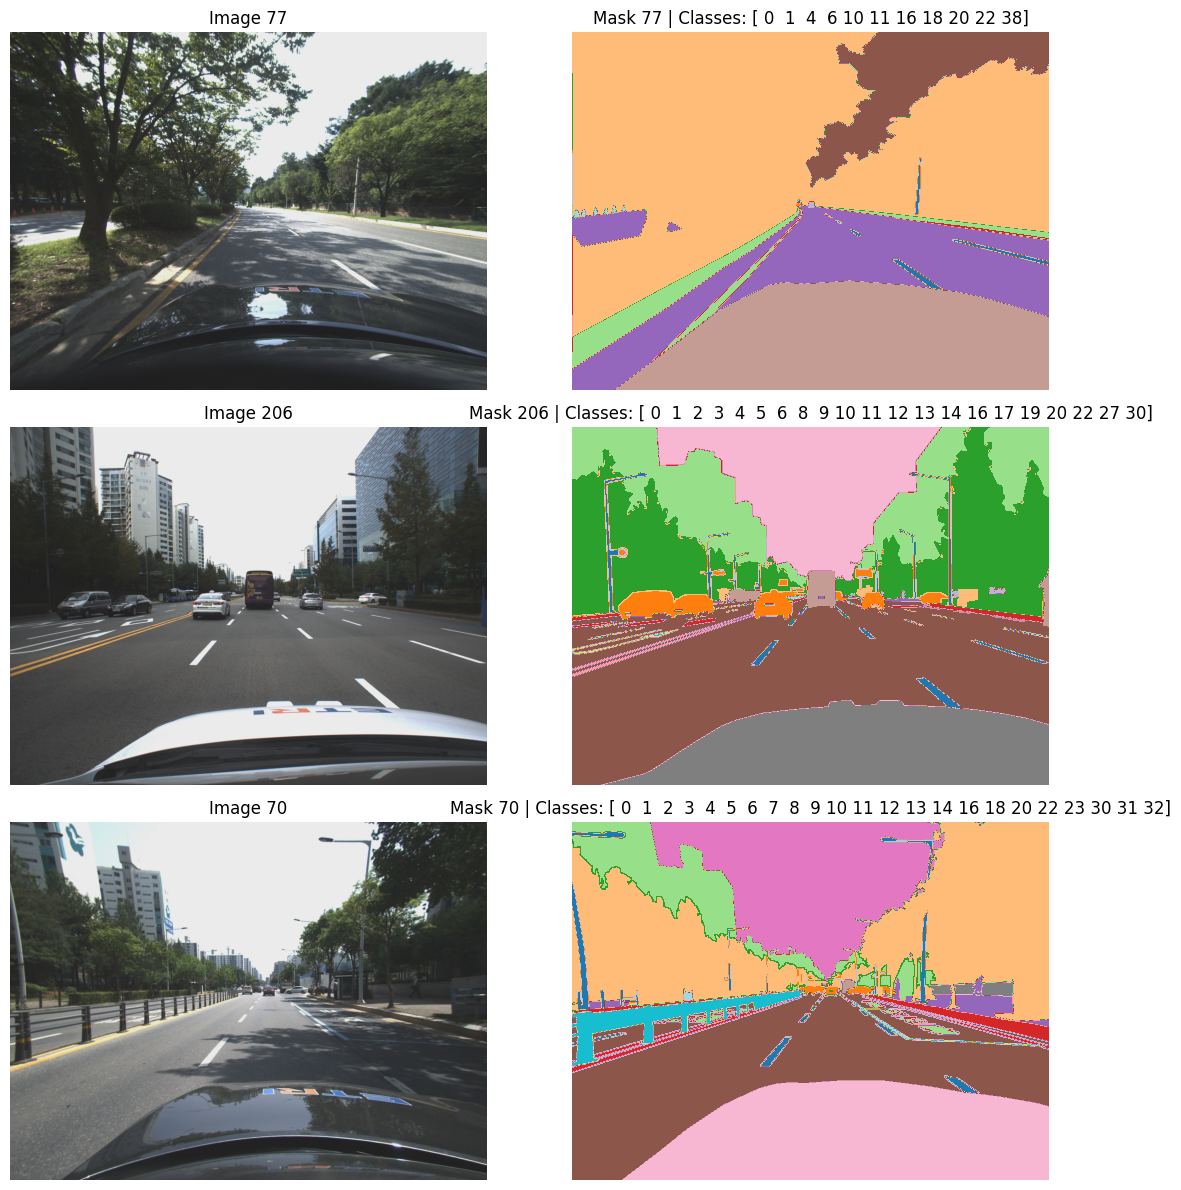

In [3]:
import random                                                                       
                                                                                    
num_samples = 3                                                                     
indices = random.sample(range(len(train_dataset)), num_samples)                                                                                     
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))             
                                                                                    
for i, idx in enumerate(indices):                                                   
    img, mask = train_dataset[idx]                                                  
                                                                                    
    # tensor → numpy (C, H, W) → (H, W, C)                                          
    img_np = img.permute(1, 2, 0).numpy()                                           
    mask_np = mask.numpy()                                                          
                                                                                    
    # 이미지                                                                        
    axes[i, 0].imshow(img_np)                                                       
    axes[i, 0].set_title(f"Image {idx}")                                            
    axes[i, 0].axis("off")                                                          
                                                                                    
    # 마스크                                                                        
    axes[i, 1].imshow(mask_np, cmap="tab20")                                        
    axes[i, 1].set_title(f"Mask {idx} | Classes: {np.unique(mask_np)}")             
    axes[i, 1].axis("off")                                                          
                                                                                    
plt.tight_layout()                                                                  
plt.show()                     

In [4]:
multi_class_info = pd.read_csv(f"{DATA_ROOT}/multi_class_info.csv")
mono_class_info = pd.read_csv(f"{DATA_ROOT}/mono_class_info.csv")

print(f"Multi Class info: {multi_class_info.shape}")
print(f"Mono Class info: {mono_class_info.shape}")

Multi Class info: (62, 3)
Mono Class info: (58, 3)


In [5]:
from src.data.dataset import get_dataset_info

mono_df = get_dataset_info(f"{DATA_ROOT}/Mono_Camera_Semantic_Segmentation", split="train")
mono_df.head()

Loading train: 100%|██████████| 210/210 [00:00<00:00, 452.66it/s]


img_path  \
0  dataset/Mono_Camera_Semantic_Segmentation/left...   
1  dataset/Mono_Camera_Semantic_Segmentation/left...   
2  dataset/Mono_Camera_Semantic_Segmentation/left...   
3  dataset/Mono_Camera_Semantic_Segmentation/left...   
4  dataset/Mono_Camera_Semantic_Segmentation/left...   

                                          label_path folder  split  width  \
0  dataset/Mono_Camera_Semantic_Segmentation/labe...      .  train   2048   
1  dataset/Mono_Camera_Semantic_Segmentation/labe...      .  train   2048   
2  dataset/Mono_Camera_Semantic_Segmentation/labe...      .  train   2048   
3  dataset/Mono_Camera_Semantic_Segmentation/labe...      .  train   2048   
4  dataset/Mono_Camera_Semantic_Segmentation/labe...      .  train   2048   

   height                                            classes  num_objects  \
0    1536  [sky, building, vegetation, building, road, si...          112   
1    1536  [sky, building, vegetation, road, wall, guard ...          130   
2    1536  [sky, building, vegetation, road, sidewalk, po...          116   
3    1536  [road, sky, vegetation, vegetation, sidewalk, ...           82   
4    1536  [road, sky, vegetation, sidewalk, building, ve...           63   

                                      unique_classes  num_classes  
0  [traffic sign, yesol, dynamic, sky, car, sidew...           23  
1  [traffic sign, dynamic, sky, car, pole, wall, ...           20  
2  [traffic sign, yesol, dynamic, right, sky, car...           25  
3  [traffic sign, yesol, dynamic, sky, sidewalk, ...           21  
4  [traffic sign, yesol, left, sky, sidewalk, pro...           21

Total classes: 58


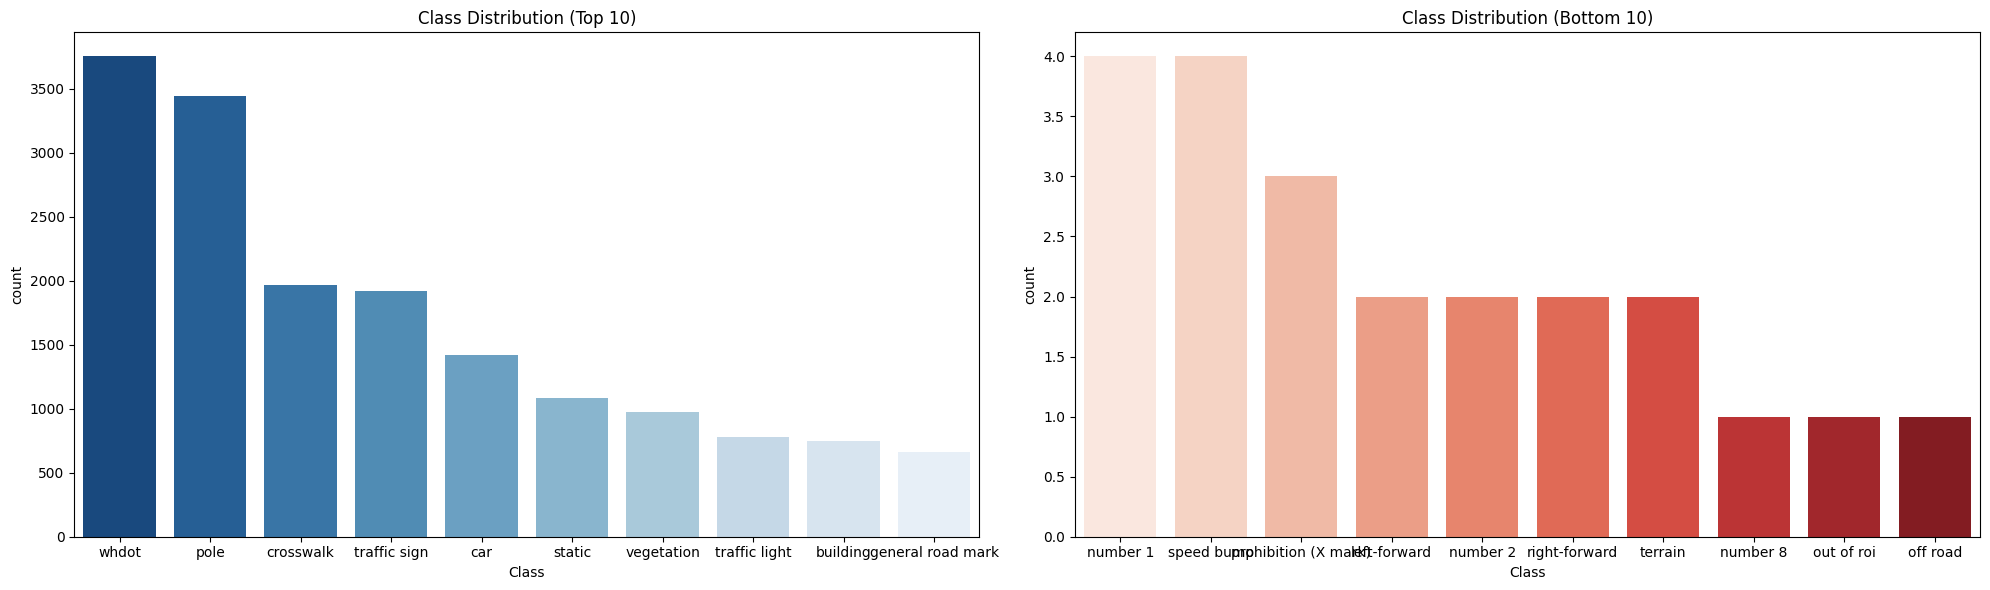

In [6]:
all_classes = []
for classes in mono_df['classes']:
    all_classes.extend(classes)

# 클래스별 등장 횟수
class_counts = Counter(all_classes)
class_df = pd.DataFrame(
    class_counts.most_common(),
    columns=['class', 'count']
)
class_df['ratio'] = class_df['count'] / class_df['count'].sum() * 100
print(f"Total classes: {len(class_df)}")

# 시각화
# 수정 부분: 서브플롯 생성 (Top 10 + Bottom 10)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Top 10
sns.barplot(
    x=class_df['class'][:10],
    y=class_df['count'][:10],
    palette='Blues_r',
    ax=axes[0]
)
axes[0].set_xlabel('Class')
axes[0].set_title('Class Distribution (Top 10)')

# Bottom 10
sns.barplot(
    x=class_df['class'][-10:],
    y=class_df['count'][-10:],
    palette='Reds',
    ax=axes[1]
)
axes[1].set_xlabel('Class')
axes[1].set_title('Class Distribution (Bottom 10)')

# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

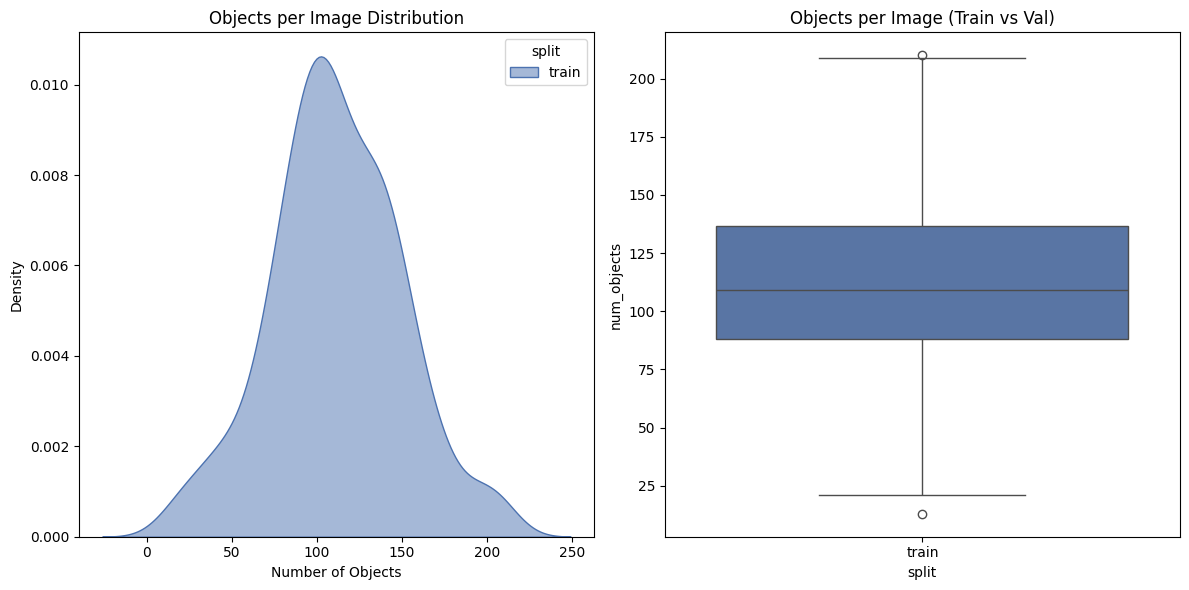

In [7]:
palette = {
    "train": "#4C72B0",  # 파랑
    # "val": "#DD8452"     # 주황
}

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(
    data=mono_df,
    x="num_objects",
    hue="split",
    fill=True,
    alpha=0.5,
    palette=palette
)
plt.xlabel("Number of Objects")
plt.ylabel("Density")
plt.title("Objects per Image Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(
    x="split",
    y="num_objects",
    data=mono_df,
    hue="split",
    palette=palette,
    legend=False
)
plt.title("Objects per Image (Train vs Val)")

plt.tight_layout()
plt.show()

In [8]:
pixel_counts = Counter()
error_count = 0
error_files = []

for i in tqdm(range(len(train_dataset)), desc="Mono Dataset"):
    try:
        _, mask = train_dataset[i]
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        for cls_id, cnt in zip(unique, counts):
            pixel_counts[cls_id] += cnt
    except Exception as e:
        error_count += 1
        error_files.append(train_dataset.get_sample_info(i)['img_path'])

print(f"\nTotal errors: {error_count} / {len(train_dataset)}")

Mono Dataset: 100%|██████████| 210/210 [00:13<00:00, 15.21it/s]


Total errors: 0 / 210


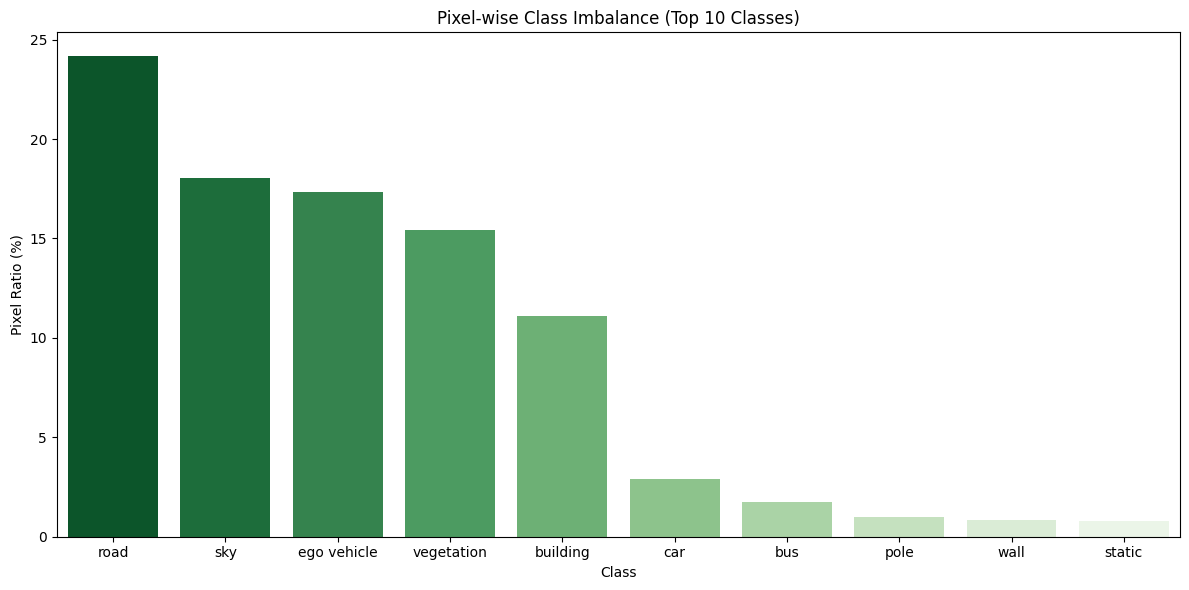

In [9]:
pixel_df = pd.DataFrame(pixel_counts.most_common(), columns=['class_id', 'pixel_count'])
pixel_df['ratio'] = pixel_df['pixel_count'] / pixel_df['pixel_count'].sum() * 100

# class name 매핑
class_info = pd.read_csv(f"{DATA_ROOT}/mono_class_info.csv")
id_to_name = dict(zip(class_info['class_id'], class_info['class_name']))
pixel_df['class_name'] = pixel_df['class_id'].map(id_to_name)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=pixel_df['class_name'][:10], y=pixel_df['ratio'][:10], palette='Greens_r')
plt.xlabel('Class')
plt.ylabel('Pixel Ratio (%)')
plt.title("Pixel-wise Class Imbalance (Top 10 Classes)")
plt.tight_layout()
plt.show()

In [10]:
q_25 = mono_class_info['count'].quantile(0.25)
df_q_25 = mono_class_info[mono_class_info['count'] <= q_25].reset_index(drop=True)
df_q_25

class_id            class_name  count
0         43                 water     14
1         44              number 3     11
2         45                ground      9
3         46                tunnel      6
4         47              number 5      6
5         48              number 1      4
6         49            speed bump      4
7         50  prohibition (X mark)      3
8         51               terrain      2
9         52          left-forward      2
10        53         right-forward      2
11        54              number 2      2
12        55              off road      1
13        56            out of roi      1
14        57              number 8      1

In [11]:
mono_classes = set(mono_class_info['class_name'])
multi_classes = set(multi_class_info['class_name'])

# mono에만 있는 클래스
only_in_mono = mono_classes - multi_classes

# multi에만 있는 클래스
only_in_multi = multi_classes - mono_classes

print(f"mono에만 있는 클래스 수: {len(only_in_mono)}")
print(f"multi에만 있는 클래스 수: {len(only_in_multi)}")

print("mono에만 있는 클래스:", sorted(only_in_mono))
print("multi에만 있는 클래스:", sorted(only_in_multi))

mono에만 있는 클래스 수: 6
multi에만 있는 클래스 수: 10
mono에만 있는 클래스: ['etc.', 'left-forward', 'number 2', 'number 8', 'off road', 'out of roi']
multi에만 있는 클래스: ['caravan', 'ground animal', 'leftU-forward', 'number 4', 'number 7', 'parking', 'polegroup', 'rail track', 'trailer', 'train']


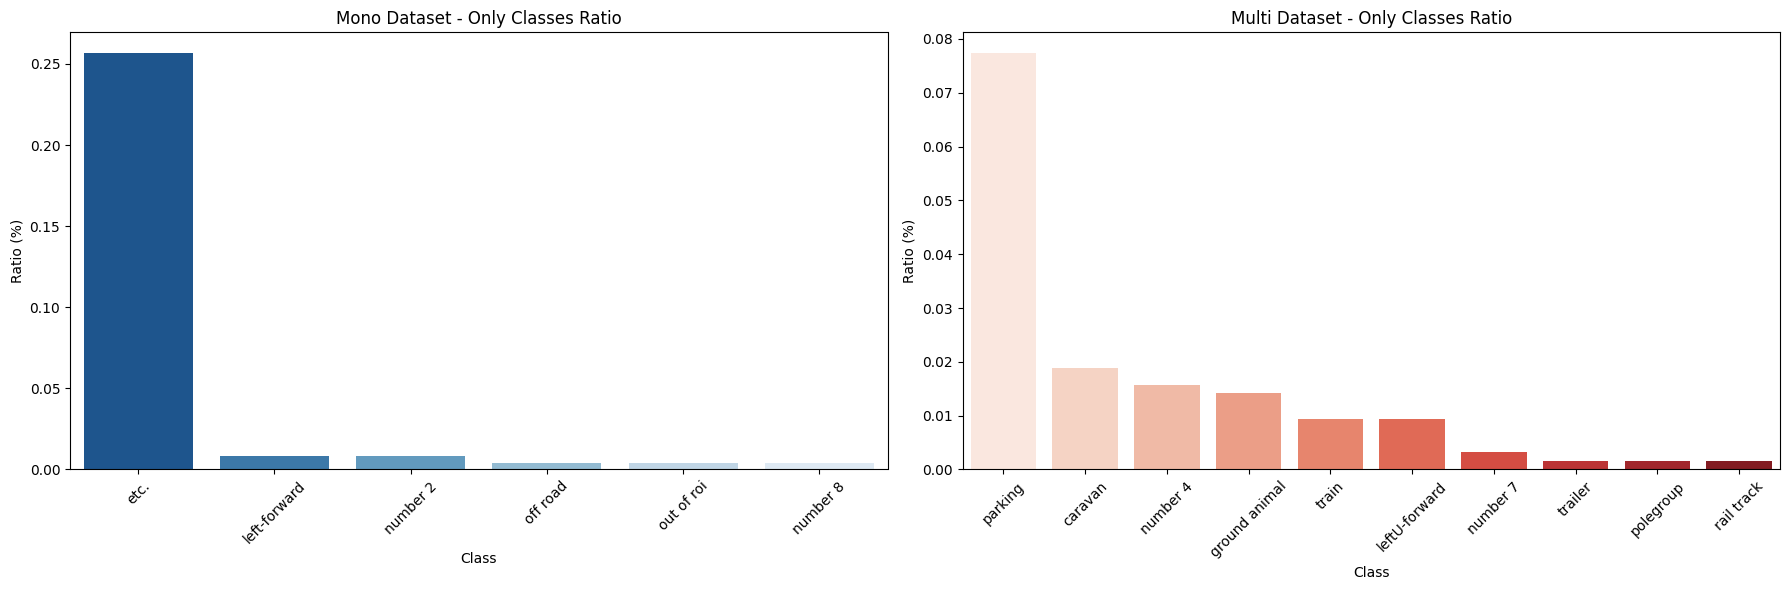

In [12]:
# mono-only 비중 계산
mono_total = mono_class_info['count'].sum()

mono_only_df = (
    mono_class_info
    [mono_class_info['class_name'].isin(only_in_mono)]
    [['class_name', 'count']]
    .copy()
)

mono_only_df['ratio'] = mono_only_df['count'] / mono_total * 100

# multi-only 비중 계산
multi_total = multi_class_info['count'].sum()

multi_only_df = (
    multi_class_info
    [multi_class_info['class_name'].isin(only_in_multi)]
    [['class_name', 'count']]
    .copy()
)

multi_only_df['ratio'] = multi_only_df['count'] / multi_total * 100

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# mono-only
sns.barplot(
    data=mono_only_df.sort_values('ratio', ascending=False),
    x='class_name',
    y='ratio',
    palette='Blues_r',
    ax=axes[0]
)
axes[0].set_title('Mono Dataset - Only Classes Ratio')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Ratio (%)')
axes[0].tick_params(axis='x', rotation=45)

# multi-only
sns.barplot(
    data=multi_only_df.sort_values('ratio', ascending=False),
    x='class_name',
    y='ratio',
    palette='Reds',
    ax=axes[1]
)
axes[1].set_title('Multi Dataset - Only Classes Ratio')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Ratio (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [13]:
multi_class_info.head()

class_id    class_name  count
0         0          pole  14713
1         1         whdot   6806
2         2  traffic sign   5151
3         3           car   3900
4         4      building   3427

In [14]:
mono_class_info.head()

class_id    class_name  count
0         0         whdot   3755
1         1          pole   3444
2         2     crosswalk   1966
3         3  traffic sign   1919
4         4           car   1419

In [20]:
multi_class_info = multi_class_info[['class_name', 'count']].reset_index(drop=True)
mono_class_info = mono_class_info[['class_name', 'count']].reset_index(drop=True)

total_class_info = pd.concat([multi_class_info, mono_class_info], ignore_index=True)
total_class_info = total_class_info.groupby('class_name', as_index=False)['count'].sum()
total_class_info = total_class_info.sort_values(by='count', ascending=False).reset_index(drop=True)
total_class_info

class_name  count
0           pole  18157
1          whdot  10561
2   traffic sign   7070
3            car   5319
4      crosswalk   4262
..           ...    ...
63    out of roi      1
64    rail track      1
65      off road      1
66     polegroup      1
67      number 8      1

[68 rows x 2 columns]

In [21]:
q_25 = total_class_info['count'].quantile(0.25)
df_q_25 = total_class_info[total_class_info['count'] <= q_25].reset_index(drop=True)
df_q_25

class_name  count
0         terrain     12
1         caravan     12
2        number 4     10
3   ground animal      9
4           train      6
5   leftU-forward      6
6        number 1      5
7   right-forward      4
8    left-forward      2
9        number 2      2
10       number 7      2
11        trailer      1
12     out of roi      1
13     rail track      1
14       off road      1
15      polegroup      1
16       number 8      1

In [ ]:
# total_class_info.to_csv(f"{PROJECT_ROOT}/{DATA_ROOT}/total_class_info.csv", index=False)

---

### Augmentation

In [1]:
import os
import json
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from collections import Counter

warnings.filterwarnings('ignore')
sys.path.append('..')
from src.utils import setup_workspace, get_device, load_config

PROJECT_ROOT = "/Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation"

setup_workspace(PROJECT_ROOT)
get_device()

Env: Local | Root: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation
Device: mps


device(type='mps')

In [6]:
from src.data.dataset import DatasetLoader
from src.data.augmentation import get_train_augmentation
from src.data.transforms import get_transforms as get_val_transforms

config = load_config("configs/config.yaml")

data_root = Path(PROJECT_ROOT) / config["data"]["root"]
img_size = tuple(config["data"]["img_size"])
class_info_path = Path(PROJECT_ROOT) / config["data"]["class_info"]

print(f"Data root: {data_root}")
print(f"Image size: {img_size}")
print(f"Class info root: {class_info_path}")

Data root: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation/dataset/Multi_Camera_Semantic_Segmentation
Image size: (768, 576)
Class info root: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation/dataset/total_class_info.csv
